# Counterfactual Explanations

This notebook walks through the use of the DiCE library to generate counterfactual explanations using an adult income dataset. I used a simple logistic regression model to classify the data, then go into how DiCE can give you alternate routes for changing a classification. At the end of the notebook, I include some explainer and visualization functions to demonstrate how these explanations can be used to better-understand bias and feasibility in the counterfactual recommendations. 

## Setup    

In [1]:
#%pip install dice-ml

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from IPython.display import display, HTML

import dice_ml
from dice_ml import Dice
from dice_ml.utils import helpers

## Load and Preprocess the Dataset

For this example notebook, we'll use the Adult Income dataset because it's a standard benchmark for fairness and interpretability, the classification task is intuitive (i.e., income >50K or not), and it contains both categorical and continuous variables, which is perfect for showcasing DiCE's capabilities. 

In [3]:
# load dataset from the UCI repository
column_names = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status", 
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", 
    "hours-per-week", "native-country", "income"
]

data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
df = pd.read_csv(data_url, header=None, names=column_names, na_values=" ?", skipinitialspace=True)

# drop rows with missing values
df.dropna(inplace=True)

# Make the target variable binary
df["income"] = df["income"].apply(lambda x: 1 if x==">50K" else 0)

# identify categorical and numerical columns
categorical = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]
numerical = ["age", "education-num", "capital-gain", "capital-loss", "hours-per-week"]

# Label encode categorical features
label_encoders = {}
for col in categorical:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le #save encoders in case they're needed later

# ensure categorical features are int (we will cast to float64 later)
for col in categorical:
    df[col] = df[col].astype(int)

# split into training and test sets
X = df.drop("income", axis=1)
y = df["income"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# normalize the numerical variables
scaler = StandardScaler()
X_train[numerical] = scaler.fit_transform(X_train[numerical])
X_test[numerical] = scaler.transform(X_test[numerical])

# set all dtypes to float64 for metadata compatibility with DiCE
X_train = X_train.astype(np.float64) 
X_test = X_test.astype(np.float64) 
df = df.astype(np.float64) 

## Train a Classifier Model 

We'll just use a simple logistic regression, as the point here is not to make the best possible classifier, but to explore the options presented by counterfactual explanations. If you want to use something like XGBoost for better classification at the outset, feel free. 

In [4]:
# train a logistic regression model
lr = LogisticRegression(max_iter=10000, random_state=41)
lr.fit(X_train, y_train)

# evaluation
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      4942
           1       0.72      0.46      0.56      1571

    accuracy                           0.83      6513
   macro avg       0.78      0.70      0.73      6513
weighted avg       0.81      0.83      0.81      6513



## Set up DiCE

To use DiCE, we need to define how the dataset is structured (including which variables are categorical and numerical), and we need to generate a wrapper that connects DiCE to our trained model

In [5]:
# define metadata for DiCE
d = dice_ml.Data(
    dataframe=df,
    continuous_features=numerical,
    categorical_features=categorical,
    outcome_name='income'
)

# wrap our trained sklearn model 
m = dice_ml.Model(model=lr, backend='sklearn')

# create DiCE explainer
exp = Dice(d, m, method='random') # Alternative methods include 'genetic', 'kdtree', 'gradient' for different generation strategies

## Generate Counterfactuals for a Random Test Instance

In [6]:

# choose a random example from the data set
query_instance = df.drop(columns=["income"]).iloc[[200]].copy()  # or use .sample(1)
query_instance[numerical] = scaler.transform(query_instance[numerical])  # scale numerical features
query_instance = query_instance.astype(np.float64)  # ensure float64 for DiCE
print("Original model prediction: ", lr.predict(query_instance)[0])

Original model prediction:  0


Now generate counterfactuals:

In [7]:
# generate 4 counterfactuals
dice_exp = exp.generate_counterfactuals(
    query_instance,
    total_CFs=4,
    desired_class="opposite"
)


  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\vscerra\AppData\Roaming\Python\Python39\site-packages\dice_ml\explainer_interfaces\dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
C:\Users\vscerra\AppData\Roaming\Python\Python39\site-packages\dice_ml\explainer_interfaces\dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '91251.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
C:\Users\vscerra\AppData\Roaming\Python\Python39\site-packages\dice_ml\explainer_interfaces\dic

## Visualization and Explainer Helper Functions

Normally, I would want to modularize this analysis a bit and place helper functions into their own container to be called up, but since this notebook is meant as a demonstration of the usage of counterfactuals, I figured I'd just lay it all out here. 

We've got one function `show_counterfactuals` that takes a single instance from the dataset, generates counterfactuals, then plots the absolute changes suggested. 

Then we've got a second function `aggregate_counterfactual_summary_across_instances` (it's a mouthful) that looks at an aggregate sample from the dataset wherein the classification goes from 0 -> 1 and counts how many times certain features are changed in counterfactual explorations, giving you an idea of how different features can contribute to improving classification (assuming you **want** a classification of 1). Explorations like this are great for understanding bias in your data. This allows you to ask "which features are consistently required to change for upward mobility?" and "Are those features modifiable? Realistic? Fair?"

In [8]:
def show_counterfactuals(cf_exp, original_instance, max_rows=10, plots=0):
    cf_df = cf_exp.cf_examples_list[0].final_cfs_df.reset_index(drop=True)
    original_df = original_instance.reset_index(drop=True)

    print("Original Instance: \n")
    display(original_df)

    print("\n Generated Counterfactuals: \n")
    display(cf_df.head(max_rows))

    for i, cf in cf_df.iterrows():
        print(f"\n Counterfactual {i+1}:")
        changes = {}
        for col in cf.index:
            if col == "income":
                continue
            orig_val = original_df.loc[0, col]
            cf_val = cf[col]
            if not np.isclose(orig_val, cf_val):
                changes[col] = abs(cf_val - orig_val)
        if changes:
            print("Changed features:")
            for change in changes:
                print(change)

            # bar chart
            if plots:
                plt.figure(figsize=(8,4))
                plt.bar(changes.keys(), changes.values(), color='steelblue')
                plt.title(f"Magnitude of Feature Changes – Counterfactual {i+1}")
                plt.ylabel("Absolute Change")
                plt.xticks(rotation=45, ha="right")
                plt.tight_layout()
                plt.show()

        else:
            print(" (No changes from original instance)")

Original Instance: 



,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,-0.921853,4.0,397317.0,12.0,1.522029,4.0,10.0,1.0,4.0,0.0,-0.145715,4.429915,-0.03151,39.0



 Generated Counterfactuals: 



,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,-0.921853,4.0,397317.0,12.0,1.522029,2.0,10.0,1.0,4.0,0.0,-0.145715,4.429915,-0.03151,39.0,1
1,-0.921853,4.0,397317.0,12.0,1.522029,4.0,10.0,1.0,2.0,0.0,-0.145715,1913.200000,-0.03151,39.0,1
2,-0.921853,0.0,397317.0,12.0,1.522029,4.0,10.0,1.0,4.0,0.0,2876.900000,4.429915,-0.03151,39.0,1
3,66.600000,4.0,397317.0,12.0,1.522029,4.0,10.0,1.0,4.0,0.0,81699.300000,4.429915,-0.03151,39.0,1



 Counterfactual 1:
Changed features:
marital-status


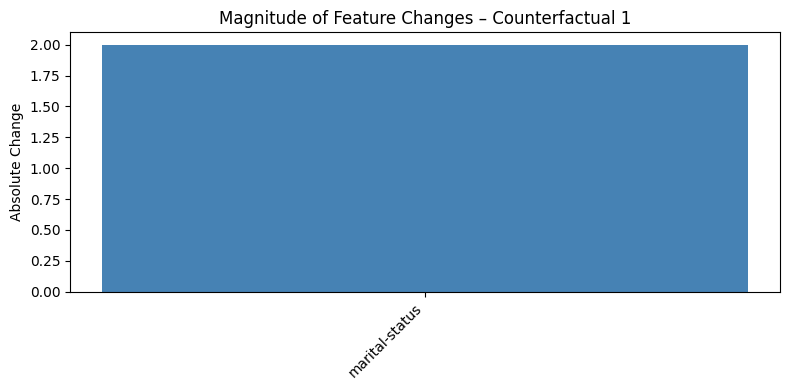


 Counterfactual 2:
Changed features:
race
capital-loss


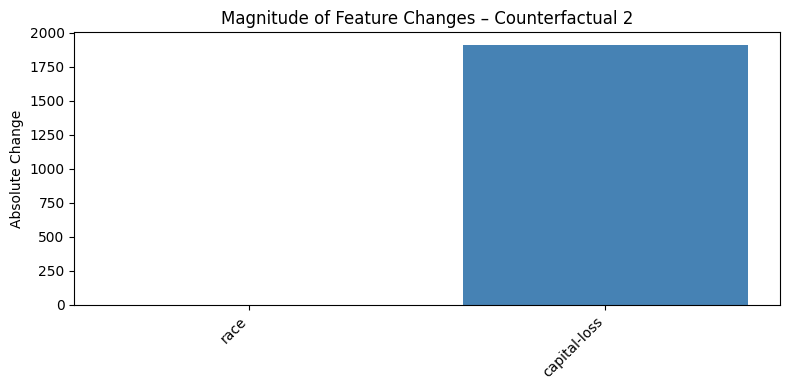


 Counterfactual 3:
Changed features:
workclass
capital-gain


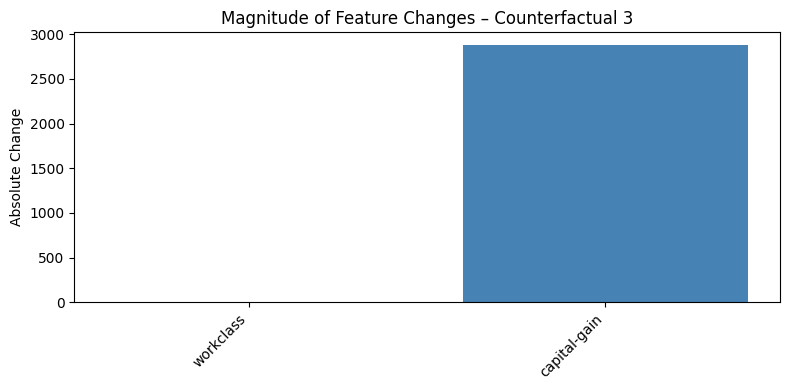


 Counterfactual 4:
Changed features:
age
capital-gain


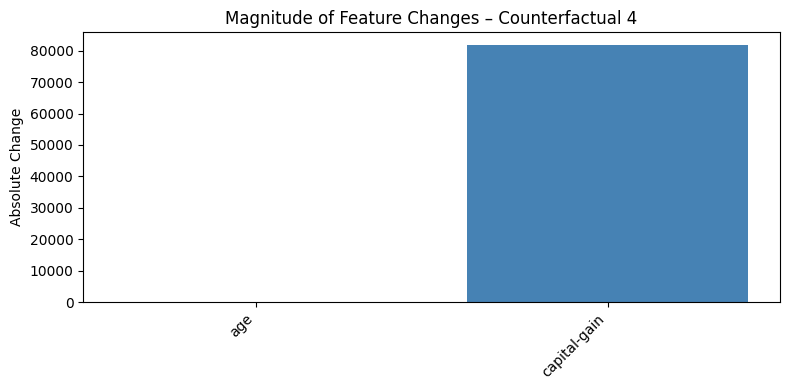

In [9]:
show_counterfactuals(dice_exp, query_instance, plots=1)

In [10]:
# this aggregate function only looks at 0 -> 1 classification changes, so instances where income is improving

def aggregate_counterfactual_summary_across_instances(df, model, scaler, exp, numerical, n_instances=10, total_CFs=4, verbose=True):
    change_counts = {}
    abs_deltas = {}

    sampled_df = df.sample(n=n_instances, random_state=42)

    for idx, (_, row) in enumerate(sampled_df.iterrows()):
        query = row.drop("income").to_frame().T.copy()
        label = row["income"]
        if label != 0: 
            continue

        query[numerical] = scaler.transform(query[numerical])
        query = query.astype(np.float64)
        if verbose:
            print(f"\n Instance {idx+1}/{n_instances}")

        try:
            cf_exp = exp.generate_counterfactuals(
                query,
                total_CFs=total_CFs,
                desired_class="opposite"
            )
            cf_df = cf_exp.cf_examples_list[0].final_cfs_df.reset_index(drop=True)
            query.reset_index(drop=True, inplace=True)

            for _, cf in cf_df.iterrows():
                if cf["income"] != 1:
                    continue
                for col in cf.index:
                    if col == "income":
                        continue
                    orig_val = query.loc[0, col]
                    cf_val = cf[col]
                    if not np.isclose(orig_val, cf_val):
                        #frequency
                        change_counts[col] = change_counts.get(col, 0) + 1
                        #delta
                        abs_deltas[col] = abs_deltas.get(col, []) + [abs(cf_val - orig_val)]
        except Exception as e:
            print(f" Skipping instance {idx+1} due to error: {e}")
            continue

    # summarize results
    freq_df = pd.DataFrame.from_dict(change_counts, orient="index", columns=["change_count"])
    mean_deltas = {k: np.mean(v) for k, v in abs_deltas.items()}
    delta_df = pd.DataFrame.from_dict(mean_deltas, orient="index", columns=["mean_abs_change"])

    result_df = freq_df.join(delta_df)
    result_df = result_df.sort_values(by="change_count", ascending=False)

    #plot
    plt.figure(figsize=(10, 5))
    plt.bar(result_df.index, result_df["change_count"], color='teal')
    plt.title(f"Feature Change Frequency (n={n_instances} instances)")
    plt.ylabel("Times Changed")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    return result_df

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\vscerra\AppData\Roaming\Python\Python39\site-packages\dice_ml\explainer_interfaces\dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
C:\Users\vscerra\AppData\Roaming\Python\Python39\site-packages\dice_ml\explainer_interfaces\dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
C:\Users\vscerra\AppData\Roaming\Python\Python39\site-packages\dice_ml\explainer_interfaces\dice_ra

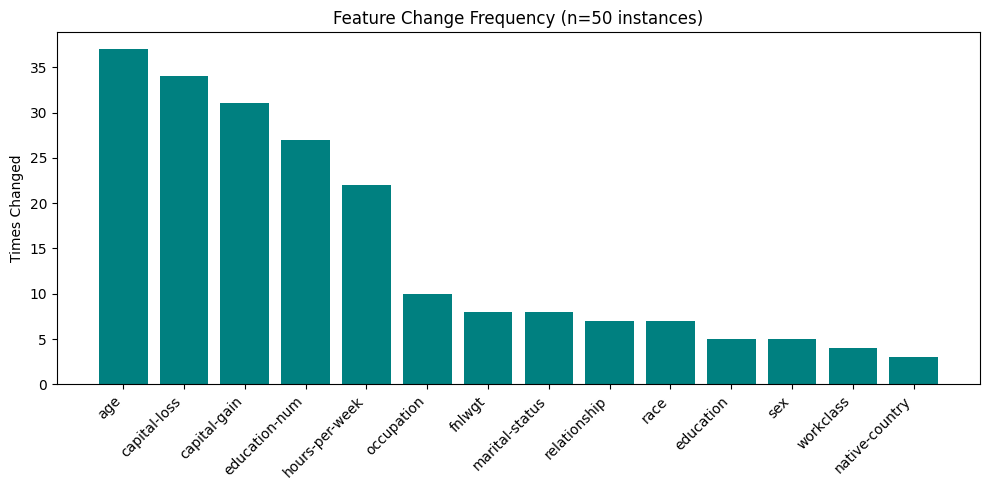

In [11]:
summary_df = aggregate_counterfactual_summary_across_instances(
    df=df,
    model=lr,
    scaler=scaler,
    exp=exp,
    numerical=numerical,
    n_instances=50,
    total_CFs=4,
    verbose=False
)

In [12]:
summary_df.head(50)

,change_count,mean_abs_change
age,37,50.348501
capital-loss,34,2606.985645
capital-gain,31,51346.222988
education-num,27,8.846149
hours-per-week,22,54.551104
occupation,10,4.400000
fnlwgt,8,95237.750000
marital-status,8,3.250000
relationship,7,2.000000
race,7,2.428571
